In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

#fetching oil data from yahoo finance
data = yf.Ticker('CL=F')
symbol = 'CL=F'
start_date = "2010-01-01"
data = yf.download('CL=F', period = 'max')

# Resetting the index to turn the date index into a column
data.reset_index(inplace=True)

data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-08-23,31.950001,32.799999,31.950001,32.049999,32.049999,79385
1,2000-08-24,31.900000,32.240002,31.400000,31.629999,31.629999,72978
2,2000-08-25,31.700001,32.099998,31.320000,32.049999,32.049999,44601
3,2000-08-28,32.040001,32.919998,31.860001,32.869999,32.869999,46770
4,2000-08-29,32.820000,33.029999,32.560001,32.720001,32.720001,49131
...,...,...,...,...,...,...,...
5925,2024-04-01,83.139999,84.489998,82.599998,83.709999,83.709999,321059
5926,2024-04-02,84.040001,85.500000,83.849998,85.150002,85.150002,344040
5927,2024-04-03,85.459999,86.199997,84.849998,85.430000,85.430000,322549
5928,2024-04-04,85.660004,87.220001,84.639999,86.589996,86.589996,322549


In [34]:
# trim dataset to relevent columns (we only need date and close to forecast prices)
data = data[['Date', 'Close']]
data

,Date,Close
0,2000-08-23,32.049999
1,2000-08-24,31.629999
2,2000-08-25,32.049999
3,2000-08-28,32.869999
4,2000-08-29,32.720001
...,...,...
5925,2024-04-01,83.709999
5926,2024-04-02,85.150002
5927,2024-04-03,85.430000
5928,2024-04-04,86.589996


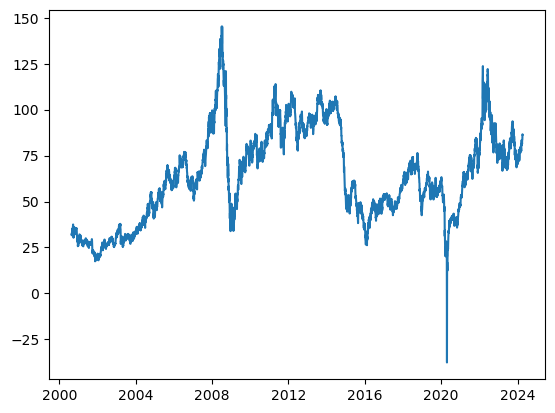

In [35]:
#simple transformations
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [36]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [37]:
#takes df from above and creates a lookback window of a week (lookback =7) 
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    
    df.set_index('Date', inplace=True)
    
    #shifts dataframe for each lookback window
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

#any greater window causes severe overfitting
lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-09-01,33.380001,33.099998,33.400002,32.720001,32.869999,32.049999,31.629999,32.049999
2000-09-05,33.799999,33.380001,33.099998,33.400002,32.720001,32.869999,32.049999,31.629999
2000-09-06,34.950001,33.799999,33.380001,33.099998,33.400002,32.720001,32.869999,32.049999
2000-09-07,35.330002,34.950001,33.799999,33.380001,33.099998,33.400002,32.720001,32.869999
2000-09-08,33.700001,35.330002,34.950001,33.799999,33.380001,33.099998,33.400002,32.720001
...,...,...,...,...,...,...,...,...
2024-04-01,83.709999,83.169998,81.349998,81.620003,81.949997,80.629997,81.070000,81.680000
2024-04-02,85.150002,83.709999,83.169998,81.349998,81.620003,81.949997,80.629997,81.070000
2024-04-03,85.430000,85.150002,83.709999,83.169998,81.349998,81.620003,81.949997,80.629997


In [38]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[33.38000107, 33.09999847, 33.40000153, ..., 32.04999924,
        31.62999916, 32.04999924],
       [33.79999924, 33.38000107, 33.09999847, ..., 32.86999893,
        32.04999924, 31.62999916],
       [34.95000076, 33.79999924, 33.38000107, ..., 32.72000122,
        32.86999893, 32.04999924],
       ...,
       [85.43000031, 85.15000153, 83.70999908, ..., 81.62000275,
        81.94999695, 80.62999725],
       [86.58999634, 85.43000031, 85.15000153, ..., 81.34999847,
        81.62000275, 81.94999695],
       [86.43000031, 86.58999634, 85.43000031, ..., 83.16999817,
        81.34999847, 81.62000275]])

In [39]:
shifted_df_as_np.shape

(5923, 8)

In [40]:
#runs scaler on data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.22359497, -0.22665644, -0.22337629, ..., -0.23813686,
        -0.24272904, -0.23813686],
       [-0.21900282, -0.22359497, -0.22665644, ..., -0.2291712 ,
        -0.23813686, -0.24272904],
       [-0.206429  , -0.21900282, -0.22359497, ..., -0.23081123,
        -0.2291712 , -0.23813686],
       ...,
       [ 0.34550629,  0.34244485,  0.32670024, ...,  0.30384876,
         0.30745683,  0.29302429],
       [ 0.35818939,  0.34550629,  0.34244485, ...,  0.3008966 ,
         0.30384876,  0.30745683],
       [ 0.35644003,  0.35818939,  0.34550629, ...,  0.32079601,
         0.3008966 ,  0.30384876]])

In [41]:
#changes df into x and y
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5923, 7), (5923,))

In [42]:
X = dc(np.flip(X, axis=1))
X

array([[-0.23813686, -0.24272904, -0.23813686, ..., -0.23081123,
        -0.22337629, -0.22665644],
       [-0.24272904, -0.23813686, -0.2291712 , ..., -0.22337629,
        -0.22665644, -0.22359497],
       [-0.23813686, -0.2291712 , -0.23081123, ..., -0.22665644,
        -0.22359497, -0.21900282],
       ...,
       [ 0.29302429,  0.30745683,  0.30384876, ...,  0.32079601,
         0.32670024,  0.34244485],
       [ 0.30745683,  0.30384876,  0.3008966 , ...,  0.32670024,
         0.34244485,  0.34550629],
       [ 0.30384876,  0.3008966 ,  0.32079601, ...,  0.34244485,
         0.34550629,  0.35818939]])

In [43]:
#use first 95% as train and last 5% as test
split_index = int(len(X) * 0.95)

split_index

5626

In [44]:
# splitting into train and test
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5626, 7), (297, 7), (5626,), (297,))

In [45]:
#PyTorch requires an extra dimension at end
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5626, 7, 1), (297, 7, 1), (5626, 1), (297, 1))

In [46]:
#wrapping in tensors for PyTorch
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5626, 7, 1]),
 torch.Size([297, 7, 1]),
 torch.Size([5626, 1]),
 torch.Size([297, 1]))

In [47]:
#need datasets object for PyTorch
#needs to be custom class
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [48]:
train_dataset

In [49]:
# wrap datasets in dataloaders to get batches
# used for iteration
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [50]:
#gives predicted outputs of arrays
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [51]:
#takes in number of features, dimensions and number of stacked layers (more layers = more complexity in model)
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        
        #initally use 1 layer to prevent overfitting in training data
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        #maps hidden layer to 1. Needed to predict final closing value
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        #initialise LSTM with default h0 and c0
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        #output is gotten from passing varibles in fully connected layer
        out = self.fc(out[:, -1, :])
        return out

#initial model has 1 input size, 4 hidden sizes and 1 stacked layer
model = LSTM(1, 4, 1) #MAPE :1.989
#model = LSTM(1, 8, 2) MAPE :2.178
#model = LSTM(1, 16, 4) MAPE :2.44
#model = LSTM(1, 4, 2) MAPE : 2.528
#model = LSTM(1, 2, 1) MAPE : 2.13
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [52]:
#sets model to training mode
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        #puts x and y batch onto device we're using 
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        #comparing model's output to ground truth
        #loss is a tensor with a single value
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        #zero out gradients 
        optimizer.zero_grad()
        #backwards pass 
        loss.backward()
        optimizer.step()

        #every 100 batches get avg loss across batches and print
        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [53]:
#sets model to validate mode
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        #don't need to calcualte gradient as there's no model updates
        with torch.no_grad():
            output = model(x_batch)
            #compare output to ground truth
            loss = loss_function(output, y_batch)
            running_loss += loss.item()
    #average loss value across all batches
    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [54]:
learning_rate = 0.001
#10 epochs is all that is necessary as any more will cause overfitting
#20 epochs caused massive overfitting for the dataset size
num_epochs = 10
#trying to minimise mean squared error
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.214
Batch 200, Loss: 0.095
Batch 300, Loss: 0.047

Val Loss: 0.002
***************************************************

Epoch: 2
Batch 100, Loss: 0.005
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002

Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.001
*****************

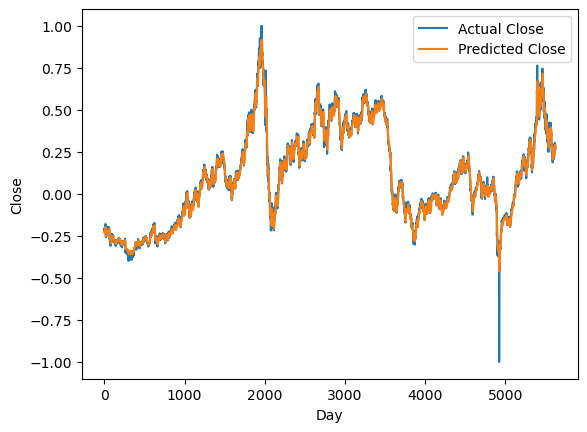

In [55]:
#no gradients for predictions
with torch.no_grad():
    #makes sure it on the device and is put to the CPU (numpy doesn't use GPU)
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [56]:
#above data still includes scalar begins at -1
#do opposite of earlier transform
train_predictions = predicted.flatten()

#lookback+1 is the length of the whole dataset
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

#return in right scale
train_predictions = dc(dummies[:, 0])
train_predictions

array([32.53077322, 32.7004793 , 32.95299412, ..., 80.31263138,
       79.9640281 , 79.09487221])

In [57]:
#first column is no y_train.flatter()
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([33.38000137, 33.79999944, 34.95000129, ..., 79.67999987,
       77.90000092, 78.87000301])

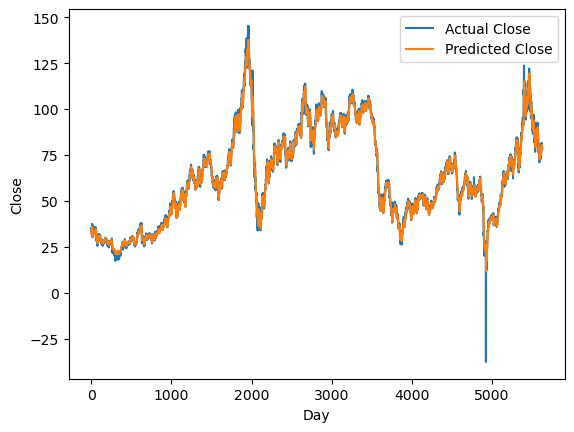

In [58]:
#same graph as earlier with different y_train and predictions
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [59]:
#convert to vector of predictions 
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([78.90705373, 77.82875332, 77.0228723 , 75.57555297, 74.92288742,
       75.60394952, 76.48051665, 76.83021294, 77.74592958, 78.48127441,
       78.63804694, 78.60434613, 78.49662022, 77.60445925, 77.02454044,
       75.78218983, 75.53600004, 75.68685776, 75.5171108 , 75.92012218,
       76.4327484 , 76.9313099 , 77.87139449, 78.70904105, 78.16321011,
       77.58068551, 76.85410115, 76.74172515, 75.92503665, 74.10346774,
       71.58927967, 70.36114097, 68.92674973, 68.33932429, 68.49425696,
       69.15114465, 69.2743881 , 69.22110844, 70.50546513, 71.45417117,
       71.97252958, 72.80920579, 73.77549817, 76.15807211, 77.73963862,
       78.66790993, 79.3369925 , 79.46063117, 80.2228516 , 81.29599495,
       81.43182305, 81.68438284, 81.22803184, 80.99460115, 80.24400319,
       79.06177652, 78.5011122 , 78.45571806, 77.74688358, 76.33185859,
       75.64103022, 75.9487804 , 75.71268396, 74.0823952 , 71.95992858,
       70.66306355, 70.88170721, 71.58328036, 72.12387793, 72.05

In [60]:
#make ground truth proper scale
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([76.41000363, 75.87999685, 73.38999955, 74.10999993, 77.13999923,
       78.47000083, 78.05999798, 79.72000254, 80.14000061, 79.05999662,
       78.58999522, 78.48999672, 76.33999623, 76.16000328, 73.94999742,
       75.38999956, 76.32000034, 75.67999985, 77.05000412, 77.69000325,
       78.16000466, 79.67999987, 80.46000017, 77.58000136, 76.66000397,
       75.72000116, 76.67999985, 74.8000024 , 71.33000234, 67.61000058,
       68.34999821, 66.73999835, 67.63999986, 69.33000233, 70.90000088,
       69.95999943, 69.26000175, 72.80999761, 73.1999964 , 72.97000148,
       74.37000231, 75.66999782, 80.4199975 , 80.70999779, 80.60999929,
       80.69999712, 79.73999843, 81.52999804, 83.26000183, 82.16000468,
       82.51999602, 80.83000308, 80.85999963, 79.1600033 , 77.29000107,
       77.87000165, 78.76000112, 77.07000001, 74.30000308, 74.76000246,
       76.77999972, 75.66000396, 71.66000394, 68.59999855, 68.55999724,
       71.3399962 , 73.16000327, 73.70999911, 72.55999727, 70.87

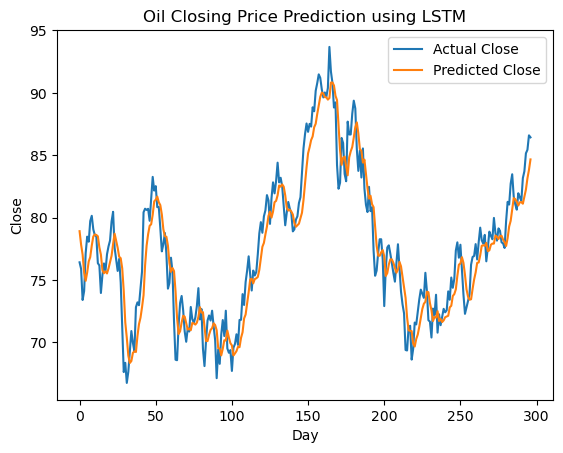

In [61]:
#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.title("Oil Closing Price Prediction using LSTM")
plt.ylabel('Close')
plt.legend()
plt.show()

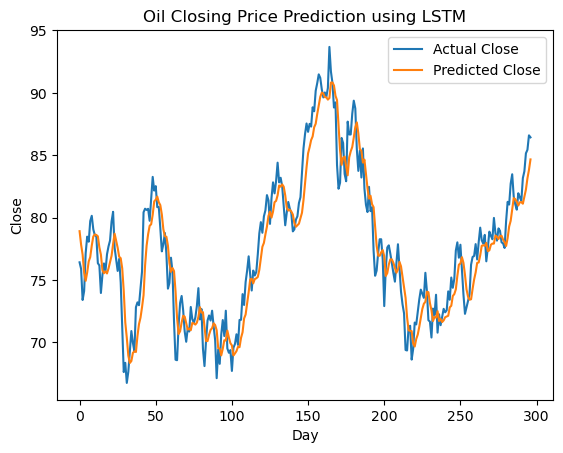

Root Mean Square Error (RMSE): 2.017920324775652
Mean Absolute Error (MAE): 1.6265661863978225
Mean Absolute Percentage Error (MAPE): 2.105624289517949


<Figure size 640x480 with 0 Axes>

In [62]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title("Oil Closing Price Prediction using LSTM")
plt.legend()
plt.show()
plt.clf()

#plt.savefig(r'C:\Users\jackc\Documents\FYP_ML_Predict\static\images\LSTM_Oil_PNG.png')
#plt.savefig(r'C:\Users\15105006\Desktop\ML_Project\static\images\LSTM_Oil_PNG.png')


# For each model, replace `actuals` and `predictions` with the corresponding variables
actuals = new_y_test
predictions = test_predictions

# Calculate the RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print("Root Mean Square Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)


In [63]:
#comparing the RMSE, MAE and MAPE for Training vs Validation data to check for overfitting
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import torch

def evaluate_model(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.view(-1).tolist())
            actuals.extend(targets.view(-1).tolist())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    
    return rmse, mae, mape

# Assuming 'train_loader' and 'test_loader' are already defined
# Evaluate the model on training data
train_rmse, train_mae, train_mape = evaluate_model(model, train_loader)
print(f'Training - RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}, MAPE: {train_mape:.3f}%')

# Evaluate the model on test (validation) data
val_rmse, val_mae, val_mape = evaluate_model(model, test_loader)  # Use test_loader as validation loader
print(f'Validation - RMSE: {val_rmse:.3f}, MAE: {val_mae:.3f}, MAPE: {val_mape:.3f}%')


Training - RMSE: 0.024, MAE: 0.016, MAPE: 3254.805%
Validation - RMSE: 0.022, MAE: 0.018, MAPE: 7.287%


The day before today for CL=F is: Date     2024-04-04 00:00:00
Close              86.589996
Name: 5928, dtype: object
The current closing price for CL=F is: 86.58999633789062


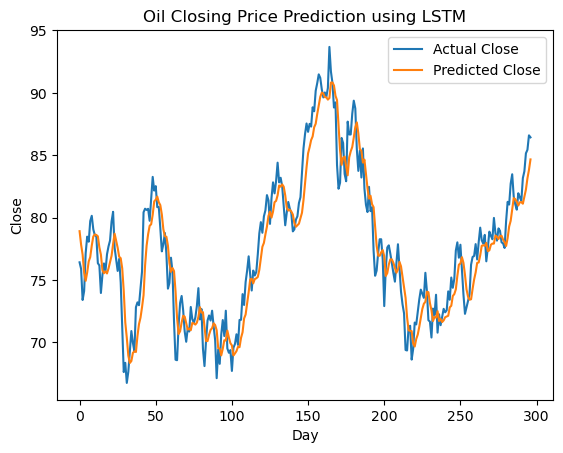

Root Mean Square Error (RMSE): 2.017920324775652
Mean Absolute Error (MAE): 1.6265661863978225
Mean Absolute Percentage Error (MAPE): 2.105624289517949
Predicted Oil price for tomorrow: 82.19903154551321


<Figure size 640x480 with 0 Axes>

In [64]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas_datareader as pdr
from datetime import datetime, timedelta
import yfinance as yf
import datetime as dt
# Get the last row of the dataframe, which corresponds to the most recent closing price
yesterday = data.iloc[-2]
print(f"The day before today for {symbol} is: {yesterday}")
current_price = yesterday['Close']
print(f"The current closing price for {symbol} is: {current_price}")

# For each model, replace `actuals` and `predictions` with the corresponding variables
actuals = new_y_test
predictions = test_predictions

#revised graph with more accurate axises 
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.title("Oil Closing Price Prediction using LSTM")
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
#plt.savefig(r'C:\Users\jackc\Documents\FYP_ML_Predict\static\images\LSTM_Oil_PNG.png')
plt.savefig(r'C:\Users\15105006\Desktop\ML_Project\static\images\LSTM_Oil_PNG.png')
plt.show()
plt.clf()

# Calculate the RMSE
rmse = sqrt(mean_squared_error(actuals, predictions))
print("Root Mean Square Error (RMSE):", rmse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(actuals, predictions)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape)
# Correcting the approach to reshape and inverse transform the prediction
latest_input = shifted_df_as_np[-1, 1:].reshape(1, lookback, 1)  # Reshape for LSTM: [1, lookback, 1]

# Convert to PyTorch tensor
latest_input_tensor = torch.tensor(latest_input).float().to(device)

# Make the prediction
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    prediction_scaled = model(latest_input_tensor).cpu().numpy()

# Prepare the data for inverse transformation correctly
prediction_scaled_expanded = np.expand_dims(prediction_scaled.flatten(), axis=0)
dummy_features = np.zeros((1, lookback))
combined_prediction = np.concatenate((prediction_scaled_expanded, dummy_features), axis=1)

# Inverse transform the prediction to get it back into the original scale
next_day_price = scaler.inverse_transform(combined_prediction)[0, 0]

print(f'Predicted Oil price for tomorrow: {next_day_price}')
import pickle
model_info = {
    'current_price': current_price,
    'next_day_price': next_day_price,
    'rmse': rmse,
    'mae': mae,
    'mape': mape
}
#with open(r'C:\Users\jackc\Documents\FYP_ML_Predict\models\LSTM_Oil.pkl', 'wb') as pkl:
   # pickle.dump(model_info, pkl)
    
with open(r'C:\Users\15105006\Desktop\ML_Project\models\LSTM_Oil.pkl', 'wb') as pkl:
    pickle.dump(model_info, pkl)